In [1]:
pwd

'/storage/kgalentino/TEST-FINAL-CHEMFLOW/ChemFlow_tutorial_a-thrombin'

In [2]:
import pandas as pd

In [3]:
VI = pd.read_csv('tutorial_chemflow/DockFlow/vina/vmd-rec/SORTED-uniq-lig.csv', delim_whitespace=True)
PL = pd.read_csv('tutorial_chemflow/DockFlow/plants/vmd-rec/SORTED-uniq-lig.csv', delim_whitespace=True)
SM = pd.read_csv('tutorial_chemflow/DockFlow/smina-vina/vmd-rec/SORTED-uniq-lig.csv', delim_whitespace=True)
VIN = pd.read_csv('tutorial_chemflow/DockFlow/smina-vinardo//vmd-rec/SORTED-uniq-lig.csv', delim_whitespace=True)
QV = pd.read_csv('tutorial_chemflow/DockFlow/qvina/vmd-rec/SORTED-uniq-lig.csv', delim_whitespace=True)

In [4]:
alldfs=[VI, PL, SM, VIN, QV]

In [5]:
# Let's remove the second column with the names of our ligand. They are already specified in the first one!

for i in alldfs:
    i.drop(columns=['LIGAND.1'], inplace=True)

In [6]:
# Let's rename the column SCORE/RMSD(SMINA-MIN) in simply "SCORE" for comodity
for i in alldfs:
    i.rename(
    columns={'SCORE/RMSD(SMINA-MIN)':"SCORE"}
          ,inplace=True)
    

In [8]:
#Let's make our negative scores positive, in order to do not have problems later on

for i in alldfs:
    i['SCORE'] = i['SCORE']*-1 
    

In [9]:
# Let's create a new column in each dataframe in which we specify the initial letter of the LIGAND name.
# This is needed to classify our compounds in true active or decoys. 
# We know that the names of our decoys start with a 'C'

for i in alldfs:
    ii = i
    ii['letter'] = i['LIGAND'].str[:1]
    classification = []
    for row in ii['letter']:
        if row == 'C' : classification.append('0') # classification for decoys
        elif row != 'C' :   classification.append('1') # classification for actives
        else:           classification.append('Error')
    ii['classification'] = classification
    print(i) 
    


       LIGAND  SCORE  EXPECTATION  CLASS letter classification
0         MID  -10.0            1      1      M              1
1         BZT   -9.4            1      1      B              1
2   C12473203   -9.2            1      0      C              0
3         MIT   -9.1            1      1      M              1
4   C12473977   -9.0            1      0      C              0
5   C04221783   -8.5            1      0      C              0
6   C12716025   -8.5            1      0      C              0
7         BT3   -8.4            0      1      B              1
8   C06860675   -8.4            0      0      C              0
9   C06134461   -8.2            0      0      C              0
10  C12467587   -8.0            0      0      C              0
11  C12473953   -8.0            0      0      C              0
12  C12479497   -8.0            0      0      C              0
13        BT1   -7.9            0      1      B              1
14  C04237042   -7.9            0      0      C        

In [10]:
# Let's convert class pandas core series of the column classification into int

import numpy as np
for x in alldfs:
    x['classification'] = x['classification'].astype(int)
    y_true = np.array(x['classification'])
    print(y_true)


[1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1]
[1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
[1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1]
[1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1]
[1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1]


In [12]:
# Let's define the function to generate Receiver operating characteristics (ROC) 
# The number of true actives is 7 and the number of decoys in our dataset is 14. 
# If you work with different datasets remmeber to modify these values!

def roc_tutorial(df, actives=7, decoys=14):
    tp = 0
    fp = 0
    tpr = []
    fpr = []

    for c in df['classification']: 
        if c == 1:
            tp+=1
        elif c == 0:
            fp+=1
        tpr.append(tp/actives)
        fpr.append(fp/decoys)
   
    
    return tpr, fpr
    

In [14]:
# Let's run the roc_tutorial function for all the tested docking programs.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

#PLANTS
aucPL = metrics.roc_auc_score(PL['classification'],  PL['SCORE'])

tprPL, fprPL = roc_tutorial(PL)


#VINA
aucVI = metrics.roc_auc_score(VI['classification'],  VI['SCORE'])

tprVI, fprVI = roc_tutorial(VI)

# QVINA

aucQV = metrics.roc_auc_score(QV['classification'],  QV['SCORE'])

tprQV, fprQV = roc_tutorial(QV)

# SMINA-VINA

aucSM = metrics.roc_auc_score(SM['classification'],  SM['SCORE'])

tprSM, fprSM = roc_tutorial(SM)


# SMINA-VINARDO

aucVIN = metrics.roc_auc_score(VIN['classification'],  VIN['SCORE'])

tprVIN, fprVIN = roc_tutorial(VIN)


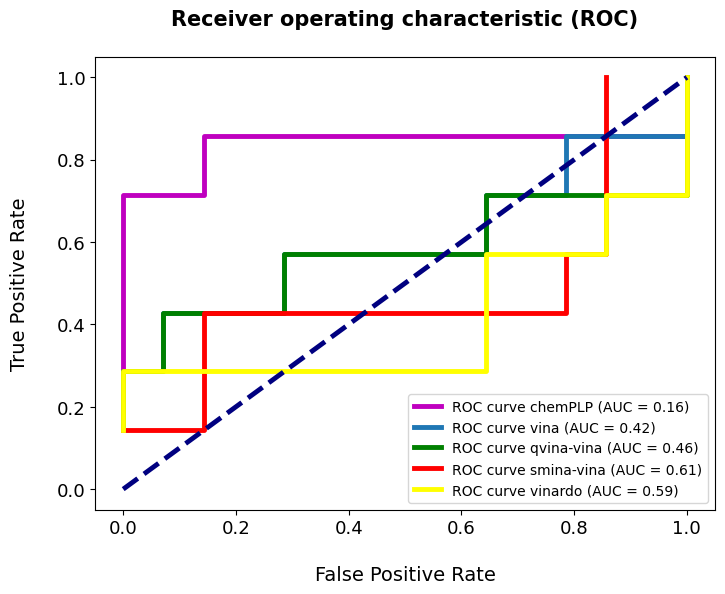

In [17]:
# PLOT the ROC and AUC for all the docking programs and save the png file in DockFlow folder

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)

lw = 3.5

plt.plot(fprPL,tprPL,label="ROC curve chemPLP (AUC = %0.2f)" % aucPL, color = 'm', lw =lw)

plt.plot(fprVI,tprVI,label="ROC curve vina (AUC = %0.2f)" % aucVI, lw =lw)

plt.plot(fprQV,tprQV,label="ROC curve qvina-vina (AUC = %0.2f)" % aucQV, color = 'green', lw =lw)

plt.plot(fprSM,tprSM,label="ROC curve smina-vina (AUC = %0.2f)" % aucSM, color = 'r', lw =lw)

plt.plot(fprVIN,tprVIN,label="ROC curve vinardo (AUC = %0.2f)" % aucVIN, color = 'yellow', lw =lw)


plt.title("Receiver operating characteristic (ROC)\n", fontweight="bold", fontsize =15)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")

plt.tick_params(axis='both', labelsize=13)

plt.xlabel("\nFalse Positive Rate",fontsize =14)

plt.ylabel("True Positive Rate\n",fontsize =14)

plt.legend(loc='best')

plt.savefig("ROC-plants-vina-qvina-smina.png", dpi=300, facecolor='white', transparent=False)